# Tensors

Pour ce tp, veuillez installer ces packages : `pip install git+https://gitlab.in2p3.fr/jbarnier/ateliers_deep_learning.git`

Les tensors sont l'une des structure de données en pytorch. Ce sont des tableaux numérique qui peuvent être utilisé par CPU ou GPU.

In [2]:
import torch

In [ ]:
list_a = [1.0, -4.0,9.0,16.0]
tensor_a = torch.tensor(list_a)
print(tensor_a)

tensor([ 1., -4.,  9., 16.])


Les calculs sur les tensors sont vectorisés. Les opérations sont donc effectué sur tout le tensor en une fois. Par exemple, ajouter une valeur à un tensors l'ajoute à chacun des éléments du tensors.

In [7]:
print(tensor_a + 2)

tensor([ 3., -2., 11., 18.])


Pytorch fournit plusieurs fonctions de calcul. Elles peuvent être appelé sous forme de fonction ou de méthode.

In [8]:
print(tensor_a.mean())
print(torch.mean(tensor_a))

tensor(5.5000)
tensor(5.5000)


**Exercice 1**

Soit la température en Fahrenheit pouvent être convertit en Celsius avec la formule suivant : 

$$T_{\textrm{Celsius}} = (T_{\textrm{Fahrenheit}} - 32) \times \frac{5}{9}$$

Crée une fonction `fahrenheit_to_celsius` qui convertit un tensor de température en Fahrenheit en Celsius. 

In [9]:
def fahrenheit_to_celsius(tensor):
    return (tensor - 32.0) * 5.0 / 9.0

temp_fahrenheit = torch.tensor([0,32,50,100])
print(fahrenheit_to_celsius(temp_fahrenheit))

tensor([-17.7778,   0.0000,  10.0000,  37.7778])


# Tensors gradients

Quand on crée un tensor, si on spécifie l'arguement `requires_grad =True` alors chaque objet créé en appliquant une opération de torch sur le tensors devriendra également un tensor qui gardera en mémoire les fonctions appliqué. 

In [ ]:
w1 = torch.tensor(1.0 , requires_grad=True)
w2 = w1 + 2.0
w3 = torch.square(w2)
print(w3)
w3.backward()  # calcule la dérivée de w3 par rapport à w1
print(w1.grad)  # montre que w1 a une fonction de gradient associée

tensor(9.6100, grad_fn=<PowBackward0>)
tensor(6.2000)


Un gradient sert à mesurer comment une quantité (souvent la perte) change quand on modifie les paramètres. Le gradient déterminé par la méthode `.backward()` utilise la règle de la chaîne pour calculer la dérivé. 

Principe : si y = f(g(x)), alors la dérivée dy/dx se calcule en multipliant la dérivée de f par rapport à g par la dérivée de g par rapport à x : dy/dx = f'(g(x)) * g'(x).


Ici on a : 
    $$w1 = 1$$
    $$w2 = w1 + 2 = 3$$
    $$w3 = w2**2 = 9$$

On a alors:
    $$dw3/dw1 = f'(g(w1)) * g'(w1)$$
            $$= f'(w2**2) * g'(w1)$$
            $$= 2 * w2 * 1$$
            $$= 2 * 3$$
            $$= 6$$

On obtient ici la pente instantannée en w1 = 1 de la dérivé. Cependant la dérivé donne une approximation linéaire locale.
Pour un petit pas Δw1, la variation de w3 est approximée par Δw3 ≈ (∂w3/∂w1) · Δw1. Cette approximation est bonne si Δw1 est petit.

Ce gradient va nous servir pour la descente de gradient appliqué à la fonction de perte (erreur du modèle) ce qui nous permettra de rendre les prédiction plus proches des vraies valeurs. (Attention on parle ici de la pente local et non global de la fonction donc pour des fonctions convexes  c'est l'idéal mais pour les fonctions non convexes on peut converger vers un minimum local qui n'est pas forcément le meilleur global).

**Exercice 2**

En utilisant les tensors :

-   calculer le gradient de la fonction $1 /\log{x}$ quand $x$ = 10. (Sauriez-vous déterminer la tendance de la fonction pour x =10 ? )
-   calculer le gradient de la fonction `farhenheit _to_celsius` quand $t$ = 0



In [13]:
# premier point d'exemple
a = torch.tensor(10.0, requires_grad=True)
a_1 = 1 / torch.log(a) 

a_1.backward()
print(a.grad)

# second point d'exemple
b = torch.tensor(0.0, requires_grad=True)
b_1 = fahrenheit_to_celsius(b)
b_1.backward()
print(b.grad)




tensor(-0.0189)
tensor(0.5556)


Quand le gradient est calculé sur une fonction avec un seul argument, la valeur correspond à la dérivé de la fonction pour un paramètre donnée.

Lorsque la fonction prend plusieurs argument en entrée, chaque valeur du gradient est la dérivée partiel de la fonction pour les paramètres données.

Pour illustrer cela, dans l’exemple suivant :

-   x1.grad est la dérivée partielle de x1/x2 par rapport à x1 lorsque x1 = 3 et x2 = 5.
-   x2.grad est la dérivée partielle de x1/x2 par rapport à x2 lorsque x1 = 3 et x2 = 5.
-   (x1.grad, x2.grad) est le gradient de x1/x2 au point (x1=3, x2=5).


In [14]:
x1 = torch.tensor(3.0, requires_grad=True)
x2 = torch.tensor(5.0, requires_grad=True)
res = x1 / x2
res.backward()
print(x1.grad, x2.grad)

tensor(0.2000) tensor(-0.1200)


**Exercise 3**

-   Créer une fonction `test_fn` qui prend deux argument `x1` et `x2` et calcul $\sqrt{x_1} / e^{x_2}$.
-   Calculer le gradient de `test_fn` quand $x_1 = 1$ et $x_2 = 2$

In [3]:
a = torch.tensor(1.0, requires_grad=True)
b = torch.tensor(2.0, requires_grad=True)

def test_fn(a,b):
    return torch.sqrt(a) / torch.exp(b)

res = test_fn(a,b)
print(res)

res.backward()

print(a.grad,b.grad)



tensor(0.1353, grad_fn=<DivBackward0>)
tensor(0.0677) tensor(-0.1353)


# Descente de gradient

Pour la suite, imaginons que nous avons un tensor `x` avec 6 valeurs numérique.

In [18]:
x = torch.tensor([1.0,2.0,3.0,20.0,-15.0,-5.0])


Nous allons utiliser une fonction prédéfinit pour afficher les valeurs sur un axe.

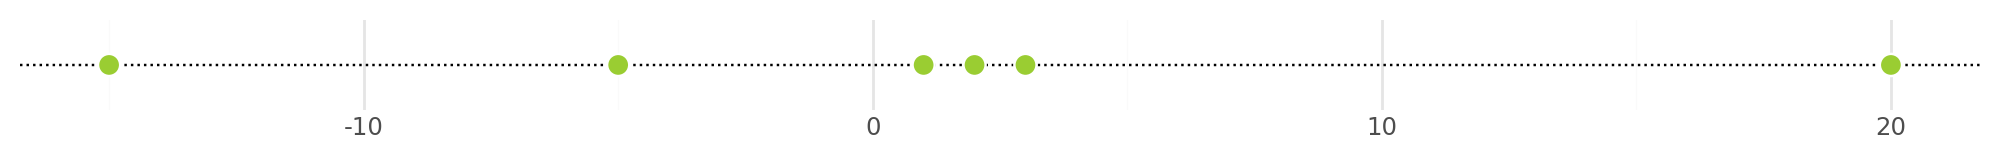

In [14]:
from adl.tensors import plot_points1d

plot_points1d(x)

Supposons que nous voulons trouver la valeur du paramètre `w` pour que la somme des distances au carré entre les valeurs de 
`x` et `w` soit minimal. 

Par exemple, on peut commencer par une valeur `w` de 0.

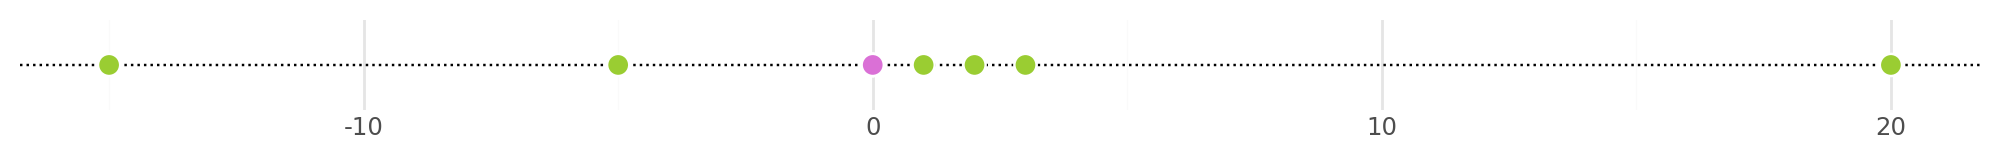

In [15]:
plot_points1d(x,0)

Pour évaluer si la distance pour `w` = 0 est minimal, on peut calculer le gradient de la fonction qui calcule la sommes des distances au carré entre les valeurs de `x` et `w` = 0.

In [19]:
w = torch.tensor(0.0, requires_grad=True)

y = (x-w).square().sum()

print(w)

y.backward()

print(w.grad)

tensor(0., requires_grad=True)
tensor(-12.)


**Point math**


On calcule la dérivée partielle en appliquant les règles de dérivation (règle de la somme, règle de la chaîne) en prenant la variable d'intérêt comme variable et en traitant les autres comme constantes. Ici nous avons 2 fonctions (le carré et la différence)

Pour bien comprendre, on va tout d'abors calculer la dérivé d'un terme i ( en suivant la règle de la chaîne et de la somme): 
- Poser u(w) = x_i − w (fonction interne).
- f_i(u) = u^2 (fonction externe).
- Appliquer la règle de la chaîne : df_i/dw = (df_i/du) · (du/dw).
- df_i/du = 2u = 2(x_i − w)
- du/dw = d(x_i − w)/dw = −1
- → df_i/dw = 2(x_i − w)·(−1) = 2(w − x_i).

Pour la somme y(w) = Σ_i f_i(w) on somme les dérivées :
- dy/dw = Σ_i 2(w − x_i) = 2·Σ_i(w) − 2·Σ_i(x_i) = 2·n·w − 2·Σ_i x_i,
- avec n = nombre d'éléments (Σ_i 1 = n).

On a alors : Σ_i x_i = 6 → dy/dw = 2·n·0 − 2·6 = −12 , avec x = [1,2,3,20,−15,−5] et w=0

(Attention ici on a bien un la même valeur pour n et Σ_i x_i, n représente le nombre de valeur dans le tensor X qui est de 6 et Σ_i x_i représente la somme des valeurs du tensor X.)